In [204]:
import math
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from scipy.stats import linregress
from scipy.fft import fft2, fftfreq
from scipy.io import savemat
from tqdm import tqdm
import re

In [231]:
# Using natural units
# eps_0 = 1
# mu_0 = 1
# c = 1
# hbar = 1
# k_B = 1
# 1 eV = 1
# In SI units,
# c = 2.99792458e8 m/s
# hbar = 6.62607015e-34/(2*pi)
# k_B = 1.380649e-23 J/K
# mu_0 = 1.25663706212e-6 J/m/A^2 (experimental)
# 1 eV = 1.602176634e-19 J
conversions = {
    "m/s": 2.99792458e8,
    "J*s": 6.62607015e-34/(2*np.pi),
    "J/K": 1.380649e-23,
    "J/m/A^2": 1.25663706212e-6,
    "J": 1.602176634e-19,
    "eV": 1
}
conversions["s"] = conversions["J*s"] / conversions["J"]
conversions["m"] = conversions["m/s"] * conversions["s"]
conversions["kg"] = conversions["J"] / conversions["m/s"]**2
conversions["g"] = conversions["kg"] / 1000
conversions["A"] = np.sqrt(conversions["J"] / conversions["m"] / conversions["J/m/A^2"])
conversions["C"] = conversions["A"] * conversions["s"]
conversions["V"] = conversions["J"] / conversions["C"]
conversions["N"] = conversions["J"] / conversions["m"]
conversions["W"] = conversions["J"] / conversions["s"]
conversions["T"] = conversions["J"] / conversions["A"] / conversions["m"]**2 
conversions["K"] = conversions["J"] / conversions["J/K"]
conversions["F"] = conversions["C"] / conversions["V"]
conversions["Hz"] = 1/conversions["s"]
conversions["rad"] = 1

In [232]:
conversions

{'m/s': 299792458.0,
 'J*s': 1.0545718176461565e-34,
 'J/K': 1.380649e-23,
 'J/m/A^2': 1.25663706212e-06,
 'J': 1.602176634e-19,
 'eV': 1,
 's': 6.582119569509067e-16,
 'm': 1.9732698045930251e-07,
 'kg': 1.7826619216278975e-36,
 'g': 1.7826619216278975e-39,
 'A': 0.0008038167088922266,
 'C': 5.290817689897897e-19,
 'V': 0.30282212087162635,
 'N': 8.119399740829861e-13,
 'W': 0.00024341348057879472,
 'T': 0.005118944531529093,
 'K': 11604.518121550082,
 'F': 1.747170145519456e-18,
 'Hz': 1519267447878626.0,
 'rad': 1}

In [242]:
prefixes = {
    'G': 1e-9,
    'M': 1e-6,
    'k': 1e-3,
    'c': 1e2,
    'm': 1e3,
    'u': 1e6,
    'p': 1e9
}
def get_conversion(unit):
    if unit in conversions:
        return conversions[unit]
    prefix, unit = unit[0], unit[1:]
    if prefix in prefixes and unit in conversions:
        return prefixes[prefix]*conversions[unit]
def conversion_ratio(unit):
    parts = re.split("([*/])", unit)
    conversion = 1
    previous = "*"
    for part in parts:
        result = 1
        if previous in ["*", "/"]:
            if '^' in part:
                left, right = part.split("^")
                result = get_conversion(left)**int(right)
            else:
                result = get_conversion(part)
            if previous == "/":
                result = 1/result
            conversion *= result
        previous = part
    return conversion
def to(unit, val):
    return val * conversion_ratio(unit)
def fr(unit, val):
    return val / conversion_ratio(unit)

In [235]:
num_points = 10000
# 1% per meter
e = fr("C", 1.602176634e-19) # = 1.602176634e-19 C by definition
c = 1 # = 2.99792458e8 m/s
m = 5.1099906e5 # m_e = 9.1093897e-31 kg
E = np.array([0, 0, 0]) # = 0 V/m
B = fr("T", np.array([1, 0, 0])) # = 1 Tesla
t_span = (0, fr("s", 100e-6)) # = 100 us
p0 = np.array([100e6, 100e6, 100e6]) # = 100 MeV
r0 = np.array([0, 0, 0]) # = 0 m
rtol = 1e-5 # = 0.001%
p_atol = 1*m/num_points
r_atol = c*t_span[1]/num_points
atol = np.array([p_atol, p_atol, p_atol, r_atol, r_atol, r_atol])
t_eval = np.linspace(*t_span, num_points) # 10000 points inside t_span

In [306]:
def gamma(p):
    return math.sqrt(1 + np.linalg.norm(p)**2/(m**2 * c**2))
def lorentz(v):
    return e * (E + np.cross(v, B) / c)
def g0(v, l, gv):
    return v * gv**2 / m**2 / c**6 * np.dot(v, v) * [np.dot(l, l) - e**2 * np.dot(v, E)**2]
def fun(t, y):
    p, r = np.split(y, 2)
    gv = gamma(p)
    v = p / (m * gv)
    l = lorentz(v)
    g = g0(v, l, gv)
    dpdt = l - 2/3 * e**2 / c * g
    drdt = v
    return np.concatenate([dpdt, drdt])
def plot(ax, u, label_u, unit_u, c=None, label_c=None, unit_c=None):
    u = to(unit_u, u)
    if c is not None:
        if unit_c is not None:
            c = to(unit_c, c)
        if u.ndim > 1 and u.shape[0] > 1:
            sc = ax.scatter(*u, c=c, cmap="hot", marker=".", s=1)
            ax.set_xlabel(f"{label_u}_x ({unit_u})")
            ax.set_ylabel(f"{label_u}_y ({unit_u})")
            if u.shape[0] > 2:
                ax.set_zlabel(f"{label_u}_z ({unit_u})")
                plt.colorbar(sc, ax=ax, location="bottom", shrink=0.5, pad=0.01, label=f"{label_c} ({unit_c})")
            else:
                plt.colorbar(sc, ax=ax, location="bottom", pad=0.1, label=f"{label_c} ({unit_c})")
        else:
            if u.ndim > 1:
                u = u[0]
            ax.scatter(c, u, marker=".", s=1)
            ax.set_xlabel(f"{label_c} ({unit_c})")
            ax.set_ylabel(f"{label_u} ({unit_u})")
    else:
        if u.ndim > 1 and u.shape[0] > 1:
            sc = ax.scatter(*u, cmap="hot", marker=".", s=1)
            ax.set_xlabel(f"{label_u}_x ({unit_u})")
            ax.set_ylabel(f"{label_u}_y ({unit_u})")
            if u.shape[0] > 2:
                ax.set_zlabel(f"{label_u}_z ({unit_u})")
    return ax
def run(fun, t, y, progress):
    progress.n = to("ms", t)
    progress.update(0)
    return fun(t, y)
def linear_fit(x, y, x_label="x", y_label="y", units=""):
    fit, cov = np.polyfit(x, y, 1, cov=True)
    uncertainty = np.sqrt(np.diag(cov))
    f = np.poly1d(fit)
    print(f"{y_label} = {fit[0]:.3}±{uncertainty[0]:.3} {x_label} + {fit[1]:.3}±{uncertainty[1]:.3} {units}")
    return f

In [252]:
y0 = np.concatenate([p0, r0])
with tqdm(total=to("ms", t_span[1]), position=to("ms", t_span[0]), bar_format='{l_bar}{bar}| {n_fmt:.7}ms/{total_fmt:.7}ms [{elapsed}<{remaining}, ' '{rate_fmt}{postfix}]', unit="ms") as progress:
    sol = solve_ivp(lambda t, y: run(fun, t, y, progress), t_span, y0, method="RK45", t_eval=t_eval, dense_output=True, rtol=rtol, atol=atol)

100%|███████████████████████████████████████████████████████████████████| 0.10000ms/0.10000ms [01:17<00:00, 777.05s/ms]


In [253]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 824852
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000018DC8389CD0>
   status: 0
  success: True
        t: array([0.00000000e+00, 1.51941939e+07, 3.03883878e+07, ...,
       1.51896356e+11, 1.51911551e+11, 1.51926745e+11])
 t_events: None
        y: array([[ 1.00000000e+08,  9.99994495e+07,  9.99988991e+07, ...,
         9.69396906e+07,  9.69395558e+07,  9.69394211e+07],
       [ 1.00000000e+08, -4.28922336e+07, -1.39379148e+08, ...,
        -4.40533136e+07, -3.07042355e+07,  5.19012435e+07],
       [ 1.00000000e+08,  1.34750047e+08,  2.38287737e+07, ...,
        -3.66395659e+07,  4.83726273e+07,  2.42572386e+07],
       [ 0.00000000e+00,  8.77246448e+06,  1.75453147e+07, ...,
         1.10775695e+11,  1.10788775e+11,  1.10801856e+11],
       [ 0.00000000e+00, -5.87416752e+05,  1.28761261e+06, ...,
         2.30977493e+06,  8.72717711e+05,  1.2803

In [259]:
t = sol.t
y = sol.y
p, r = np.split(y, 2)

In [301]:
v = p / (m * gamma(p_sol))
r_corr = r - np.tile(np.mean(r, axis=1), (r.shape[1],1)).T
v_corr = v - np.tile(np.mean(v, axis=1), (v.shape[1],1)).T
omega = np.cross(r_corr, v_corr, axis=0)/np.linalg.norm(r_corr[1:], axis=0)**2
beta_perp = np.linalg.norm(v_corr[1:], axis=0)/c
beta = np.linalg.norm(v_corr, axis=0)/c
P = 2*(e*omega[0])**2/(3*c)*(beta_perp**2)/(1 - beta**2)
frequency = 2 * np.pi * np.abs(omega[0])
period = 1/frequency

In [261]:
standard_figsize = (8, 6)
square_figsize = (7.5, 10)
double_square_figsize = (15, 10)

<Axes3DSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

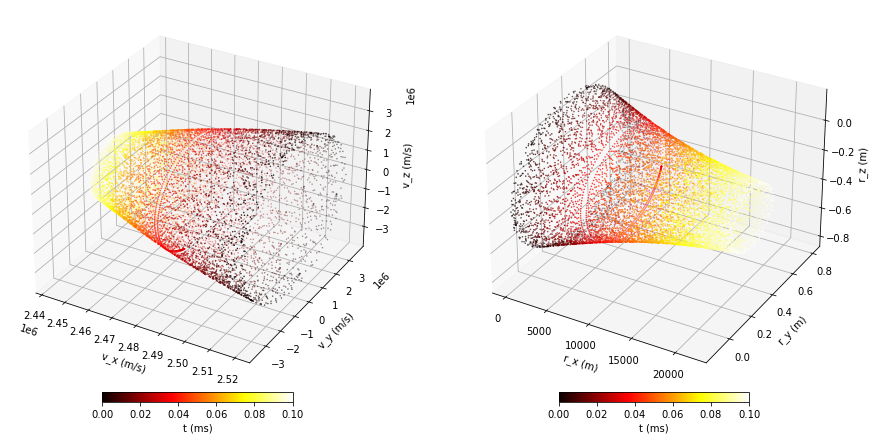

In [264]:
fig, axs = plt.subplots(1, 2, figsize=double_square_figsize, subplot_kw=dict(projection="3d"))
plot(axs[0], v, "v", "m/s", t, "t", "ms")
plot(axs[1], r, "r", "m", t, "t", "ms")

<AxesSubplot:xlabel='t (ms)', ylabel='p (kg*m/s)'>

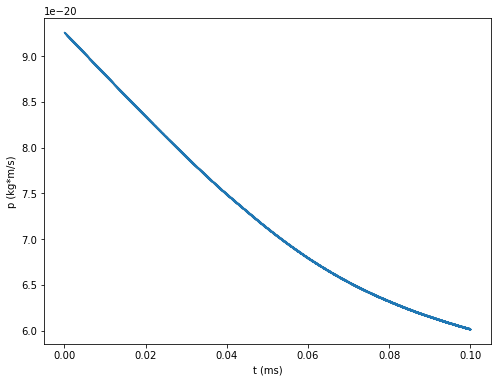

In [294]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.linalg.norm(p, axis=0), "p", "kg*m/s", t, "t", "ms")

<AxesSubplot:xlabel='t (ms)', ylabel='E (eV)'>

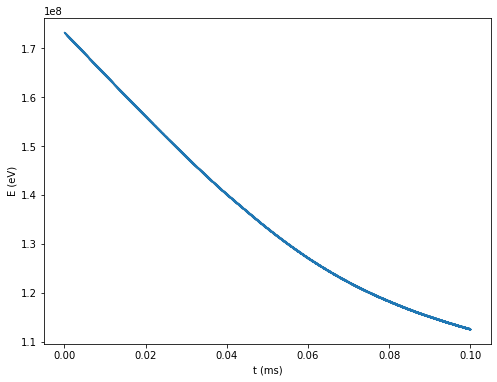

In [295]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.sqrt(np.linalg.norm(p, axis=0)**2 + (m*c**2)**2), "E", "eV", t, "t", "ms")

<AxesSubplot:xlabel='t (ms)', ylabel='r (m)'>

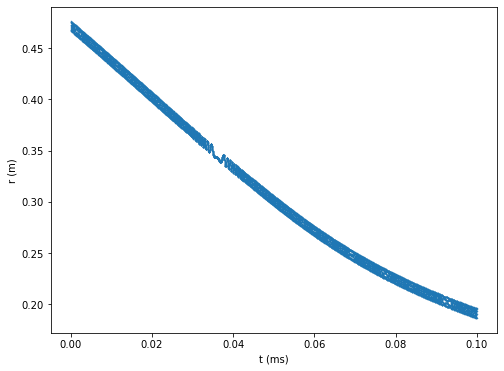

In [296]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.linalg.norm(r_corr[1:], axis=0), "r", "m", t, "t", "ms")

<AxesSubplot:xlabel='t (ms)', ylabel='v (m/s)'>

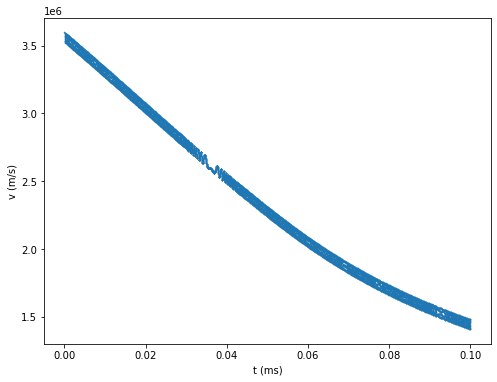

In [297]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.linalg.norm(v_corr[1:], axis=0), "v", "m/s", t, "t", "ms")

<AxesSubplot:xlabel='t (ms)', ylabel='f (Hz)'>

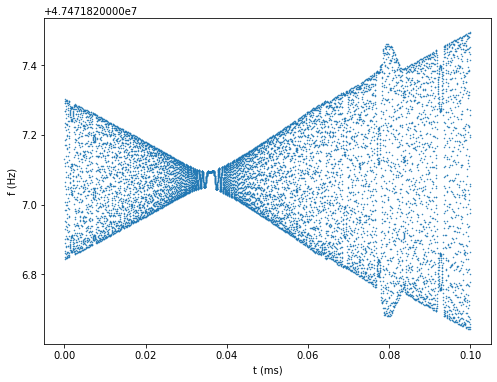

In [302]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), frequency, "f", "Hz", t, "t", "ms")

<AxesSubplot:xlabel='t (ms)', ylabel='T (s)'>

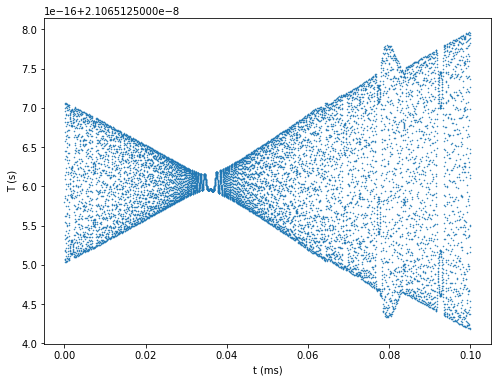

In [303]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), period, "T", "s", t, "t", "ms")

<AxesSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

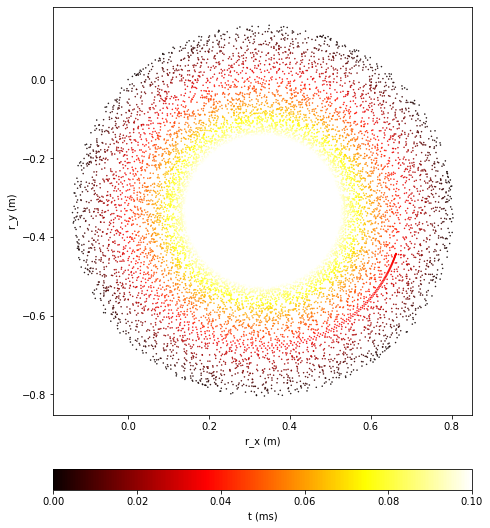

In [307]:
plt.figure(figsize=square_figsize)
plot(plt.axes(), r[1:], "r", "m", t, "t", "ms")

<AxesSubplot:xlabel='v_x (m/s)', ylabel='v_y (m/s)'>

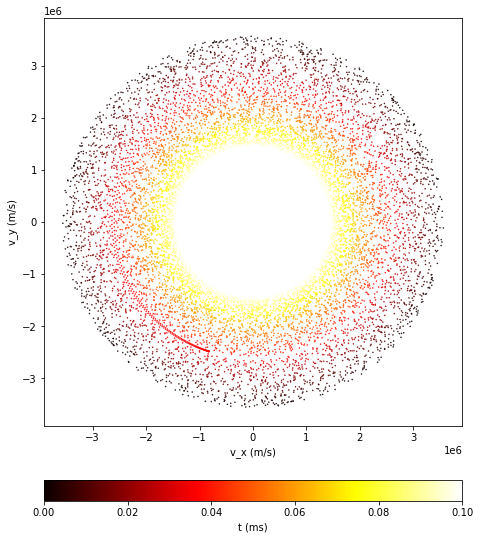

In [308]:
plt.figure(figsize=square_figsize)
plot(plt.axes(), v[1:], "v", "m/s", t, "t", "ms")

<AxesSubplot:xlabel='t (ms)', ylabel='P (W)'>

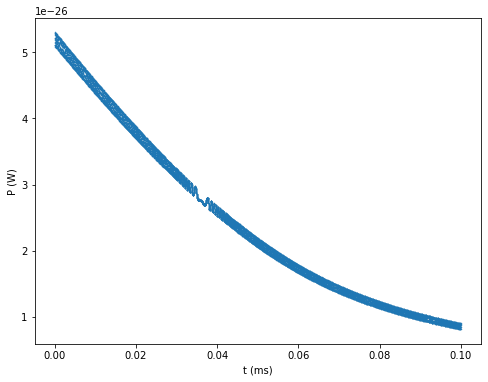

In [310]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), P, "P", "W", t, "t", "ms")